In [31]:
import numpy as np 
import pandas as pd 
import pickle 
from collections import Counter 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader


In [32]:
# import data 
file_path = r'/Users/giammarcocellini/Desktop/nlp/applied_nlp_python_course/data/Tweets.csv'
df = pd.read_csv(file_path).dropna()
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [33]:
cat_id = {'negative':0,
          'neutral':1,
          'positive':2}

df['class'] = df['sentiment'].map(cat_id)
df['class'].value_counts()


class
1    11117
2     8582
0     7781
Name: count, dtype: int64

In [34]:
# hyperparameters 
BATCH_SIZE = 128
NUM_EPOCHS = 80
MAX_FEATURES = 10

In [5]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')
embeddings = model.encode(sentences)
print(embeddings)

/Users/giammarcocellini/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
config_sentence_transformers.json: 100%|██████████| 116/116 [00:00<00:00, 286kB/s]
README.md: 100%|██████████| 9.90k/9.90k [00:00<00:00, 18.9MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 112kB/s]
config.json: 100%|██████████| 591/591 [00:00<00:00, 906kB/s]
model.safetensors: 100%|██████████| 438M/438M [00:40<00:00, 10.9MB/s] 
tokenizer_config.json: 100%|██████████| 363/363 [00:00<00:00, 976kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.02MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 1.49MB/s]
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<00:00, 526kB/s]


[[ 0.03601315 -0.03482058 -0.0084838  ... -0.04571353  0.02780311
  -0.01912106]
 [ 0.04001369  0.00855442 -0.01886307 ... -0.0060088  -0.05130467
  -0.02208149]]


In [7]:
print(embeddings.squeeze().shape)

(2, 768)


In [9]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')
x = model.encode(sentences=df['text'].values)

In [16]:
with open(r'/Users/giammarcocellini/Desktop/nlp/applied_nlp_python_course/data/Tweets_x.pickle','wb') as output_file:
    pickle.dump(x, output_file)


In [35]:

with open(r'/Users/giammarcocellini/Desktop/nlp/applied_nlp_python_course/data/Tweets_x.pickle','rb') as input_file:
    x = pickle.load(input_file)

In [36]:
x.shape

(27480, 768)

In [37]:
y = df['class'].values

In [38]:
# train test split 
x_train , x_test, y_train, y_test = train_test_split(
    x, y , test_size= 0.5, random_state=123
)

In [39]:
class SentimentData(Dataset):
    def __init__(self, X,y):
        super().__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
train_ds = SentimentData(X = x_train , y = y_train)
test_ds = SentimentData(X = x_test, y = y_test)


In [40]:
train_loader = DataLoader(dataset = train_ds,
                          batch_size= BATCH_SIZE,
                          shuffle = True)
test_loader = DataLoader(dataset = test_ds, batch_size = 15000)


In [41]:
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN = 10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim  =1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [42]:
# model , loss, optimizer

model = SentimentModel(NUM_FEATURES=x_train.shape[1],
                       NUM_CLASSES=3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())


In [43]:
# training
train_losses = []

for e in range(NUM_EPOCHS):
    curr_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(x_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(curr_loss)
    print(f'Epoch {e}, Loss: {curr_loss}')

Epoch 0, Loss: 111.41731715202332
Epoch 1, Loss: 91.93635165691376
Epoch 2, Loss: 82.0493391752243
Epoch 3, Loss: 78.393075466156
Epoch 4, Loss: 76.33755534887314
Epoch 5, Loss: 74.99187076091766
Epoch 6, Loss: 74.07953119277954
Epoch 7, Loss: 73.33856093883514
Epoch 8, Loss: 72.73187643289566
Epoch 9, Loss: 72.11603629589081
Epoch 10, Loss: 71.56425261497498
Epoch 11, Loss: 71.04268303513527
Epoch 12, Loss: 70.7661160826683
Epoch 13, Loss: 70.47696852684021
Epoch 14, Loss: 69.95616388320923
Epoch 15, Loss: 69.66580802202225
Epoch 16, Loss: 69.24910229444504
Epoch 17, Loss: 69.01334244012833
Epoch 18, Loss: 68.67149710655212
Epoch 19, Loss: 68.47966223955154
Epoch 20, Loss: 68.0443449318409
Epoch 21, Loss: 67.84467932581902
Epoch 22, Loss: 67.6484243273735
Epoch 23, Loss: 67.45716601610184
Epoch 24, Loss: 67.07689329981804
Epoch 25, Loss: 66.78169652819633
Epoch 26, Loss: 66.56167435646057
Epoch 27, Loss: 66.42502403259277
Epoch 28, Loss: 66.17506954073906
Epoch 29, Loss: 65.8528165221

<Axes: >

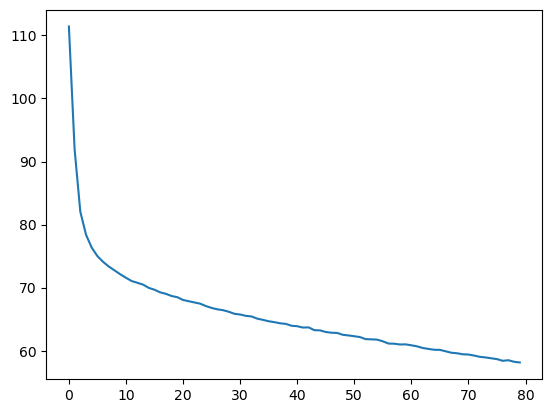

In [44]:
sns.lineplot(x= list(range(len(train_losses))), y = train_losses)

In [49]:
with torch.no_grad():
    for x_b, y_b in test_loader:
        y_test_pred_log = model(x_b)
        y_test_pred = torch.argmax(y_test_pred_log, dim =1)

y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

In [50]:

acc = accuracy_score(y_pred=y_test_pred_np, y_true = y_test)
f"The accuracy of the model is {np.round(acc, 3)*100}%."

'The accuracy of the model is 68.0%.'

In [51]:

most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_cnt / len(y_test) * 100, 1)} %")

Naive Classifier: 41.0 %
